In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pydot
from time import time

In [2]:
class TrieNode:
    def __init__(self, letter = '', parent = None):
        self.letter = letter
        self.parent = parent
        self.children = dict()

    def add_child(self, letter):
        new_node = TrieNode(letter, self)
        self.children[letter] = new_node
        return new_node

    def __str__(self):
        return f"TrieNode: letter={self.letter}, children={self.children.keys()}, parent_letter={self.parent.letter if self.parent is not None else 'NONE'}"

class Trie:
    def __init__(self, text):
        self.text = text
        self.root = TrieNode()
        self.n = len(text)
        self.build_trie()

    def build_trie(self):
        for i in range(self.n):
            start, head = self.find_head(i)
            self.graft(start, head)

    def find_head(self, start):
        node = self.root
        i = start
        while self.text[i] in node.children:
            node = node.children[self.text[i]]
            i += 1

        return i, node

    def graft(self, start, node):
        for i in range(start, self.n):
            node = node.add_child(self.text[i])

    def __contains__(self, pattern):
        node = self.root
        for x in pattern:
            if x in node.children:
                node = node.children[x]
            else:
                return False
        return True

In [3]:
class SuffixTreeNode:
    def __init__(self, letter="", start=0, end=0, parent = None):
        self.letter = letter
        self.parent = parent
        self.start = start
        self.end = end
        self.children = dict()

    def add_child(self, letter, start, end):
        new_node = SuffixTreeNode(letter, start, end, self)
        self.children[letter] = new_node
        return new_node

    def split(self, split_index, split_letter, letter, start, end):
        split_node = SuffixTreeNode(self.letter, self.start, split_index - 1, self.parent)
        self.parent.children[self.letter] = split_node
        split_node.children[split_letter] = self

        self.start = split_index
        self.letter = split_letter
        self.parent = split_node
        new_node = SuffixTreeNode(letter, start, end, split_node)
        split_node.children[letter] = new_node
        return new_node

    def __str__(self):
        return f"SuffixTreeNode: {(self.start, self.end)}, children={self.children.keys()}"

class SuffixTree:
    def __init__(self, text):
        self.text = text
        self.root = SuffixTreeNode()
        self.n = len(text)
        self.build_tree()

    def build_tree(self):
        for i in range(self.n):
            find = self.find_head(i)
            if find[0] == 0:
                _, start, head = find
                head.add_child(self.text[start], start, self.n - 1)
            else:
                _, start, split_index, head = find
                head.split(split_index, self.text[split_index], self.text[start], start, self.n - 1)

    def find_head(self, idx):
        node = self.root
        i = idx
        while self.text[i] in node.children:
            node = node.children[self.text[i]]
            j = node.start
            end = node.end
            while j <= end and self.text[i] == self.text[j]:
                i += 1
                j += 1

            if j <= end:
                return 1, i, j, node

        return 0, i, node

    def __contains__(self, pattern):
        node = self.root
        i = 0
        while i < len(pattern):
            if pattern[i] in node.children:
                node = node.children[pattern[i]]
                j = node.start
                while i < len(pattern) and j <= node.end:
                    if pattern[i] != self.text[j]:
                        return False
                    i += 1
                    j += 1
            else:
                return False
        return True

In [4]:
class TreeVisualization:
    def __init__(self):
        self.G = nx.Graph()

    def trie_tree(self, node, node_i):
        i = node_i
        for letter, child in node.children.items():
            child_i, i = self.trie_tree(child, i + 1)
            self.G.add_edge(node_i, child_i, letters=letter)
        return node_i, i

    def suffix_tree(self, node, node_i):
        i = node_i
        for letter, child in node.children.items():
            child_i, i = self.suffix_tree(child, i + 1)
            self.G.add_edge(node_i, child_i, letters=f"{letter}\n[{child.start}, {child.end}]")
        return node_i, i

    def plot_trie_tree(self, root):
        self.trie_tree(root, 0)
        self.plot()

    def plot_suffix_tree(self, root):
        self.suffix_tree(root, 0)
        self.plot()

    def plot(self):
        nodes = sorted(self.G.nodes(data=True))
        edges = sorted(self.G.edges(data=True))
        self.G.clear()
        self.G.add_nodes_from(nodes)
        self.G.add_edges_from(edges)

        plt.figure(figsize=(18, 9))
        pos = nx.drawing.nx_pydot.pydot_layout(self.G, prog="dot")
        nx.draw(self.G, pos=pos)
        labels = nx.get_edge_attributes(self.G, 'letters')
        nx.draw_networkx_edge_labels(self.G, pos, font_size=14, edge_labels=labels, rotate=False)
        plt.show()

In [5]:
def check_correctness(tree, tests, text, structure_name, long=False):
    print(f"Testowana struktura: {structure_name}")
    print(f"Testowany tekst: {text}")
    correct = True
    for pattern, correct_res in tests:
        if len(pattern) > 20:
            print(f" -> Wzorzec: {pattern[:17]}...  Poprawny wynik: {correct_res}\t  Otrzymany wynik: {pattern in tree}")
        elif not long:
            print(f" -> Wzorzec: {pattern:<10}  Poprawny wynik: {correct_res}\t  Otrzymany wynik: {pattern in tree}")
        else:
            print(f" -> Wzorzec: {pattern:<20}  Poprawny wynik: {correct_res}\t  Otrzymany wynik: {pattern in tree}")

        if (pattern in tree) != correct_res:
            correct = False
    print("Struktura danych jest poprawna\n" if correct else "Struktura danych nie jest poprawna\n")

## Tekst bbb$

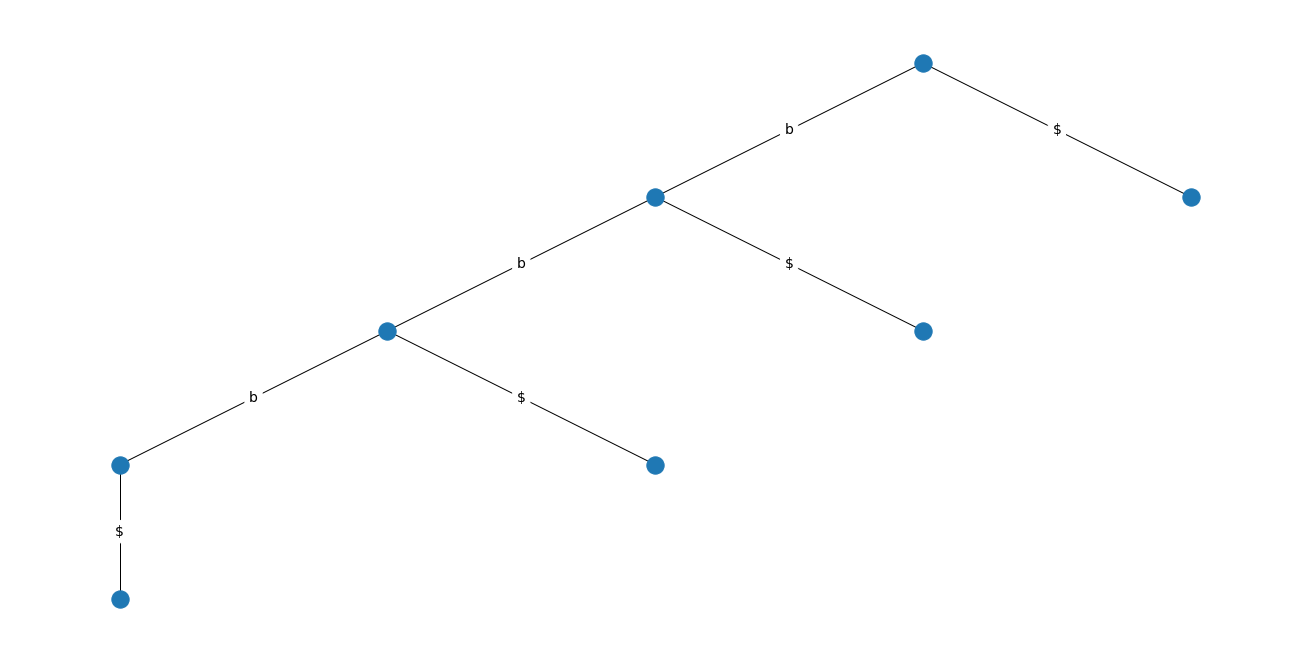

In [6]:
trie = Trie("bbb$")
tv = TreeVisualization()
tv.plot_trie_tree(trie.root)

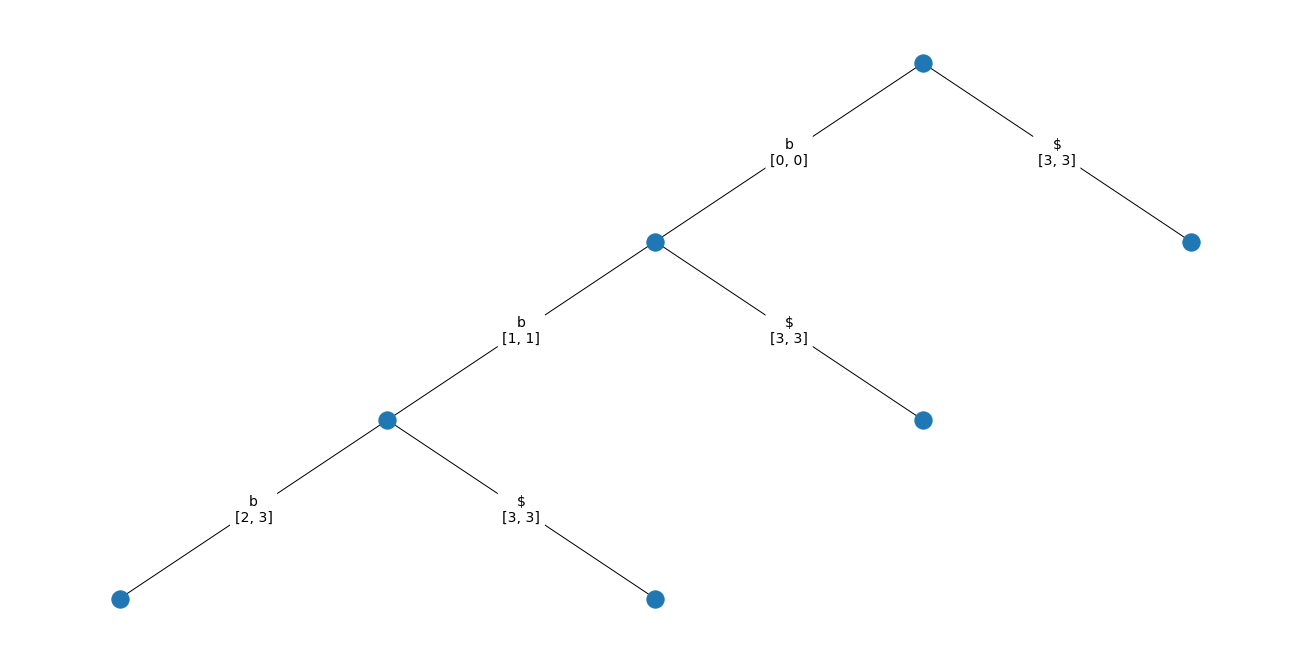

In [7]:
suffix_tree = SuffixTree("bbb$")
tv = TreeVisualization()
tv.plot_suffix_tree(suffix_tree.root)

#### Sprawdzenie poprawności dla tekstu bbb$

In [8]:
tests = [("b", True), ("bbb", True), ("bbb$", True), ("bbbb", False), ("b$*&", False), ("b$", True)]
check_correctness(trie, tests, "aabbabd", "Trie")
check_correctness(suffix_tree, tests, "aabbabd", "Suffix Tree")

Testowana struktura: Trie
Testowany tekst: aabbabd
 -> Wzorzec: b           Poprawny wynik: True	  Otrzymany wynik: True
 -> Wzorzec: bbb         Poprawny wynik: True	  Otrzymany wynik: True
 -> Wzorzec: bbb$        Poprawny wynik: True	  Otrzymany wynik: True
 -> Wzorzec: bbbb        Poprawny wynik: False	  Otrzymany wynik: False
 -> Wzorzec: b$*&        Poprawny wynik: False	  Otrzymany wynik: False
 -> Wzorzec: b$          Poprawny wynik: True	  Otrzymany wynik: True
Struktura danych jest poprawna

Testowana struktura: Suffix Tree
Testowany tekst: aabbabd
 -> Wzorzec: b           Poprawny wynik: True	  Otrzymany wynik: True
 -> Wzorzec: bbb         Poprawny wynik: True	  Otrzymany wynik: True
 -> Wzorzec: bbb$        Poprawny wynik: True	  Otrzymany wynik: True
 -> Wzorzec: bbbb        Poprawny wynik: False	  Otrzymany wynik: False
 -> Wzorzec: b$*&        Poprawny wynik: False	  Otrzymany wynik: False
 -> Wzorzec: b$          Poprawny wynik: True	  Otrzymany wynik: True
Struktura d

## Tekst aabbabd

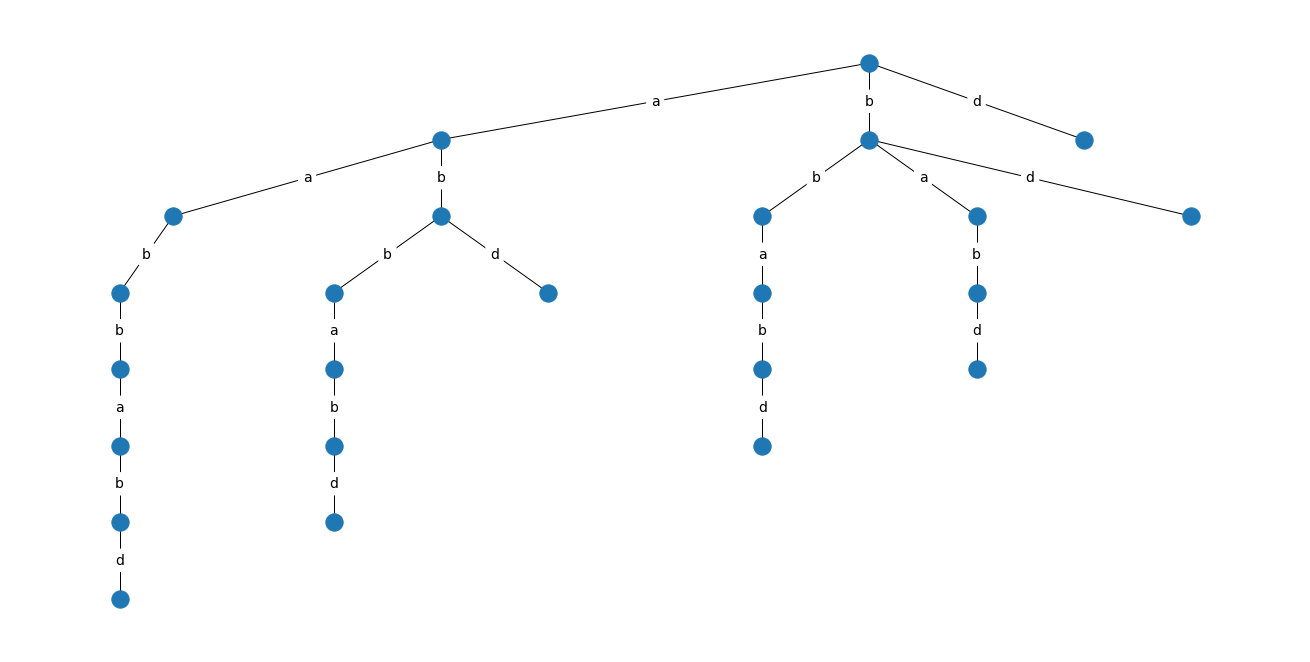

In [9]:
trie = Trie("aabbabd")
tv = TreeVisualization()
tv.plot_trie_tree(trie.root)

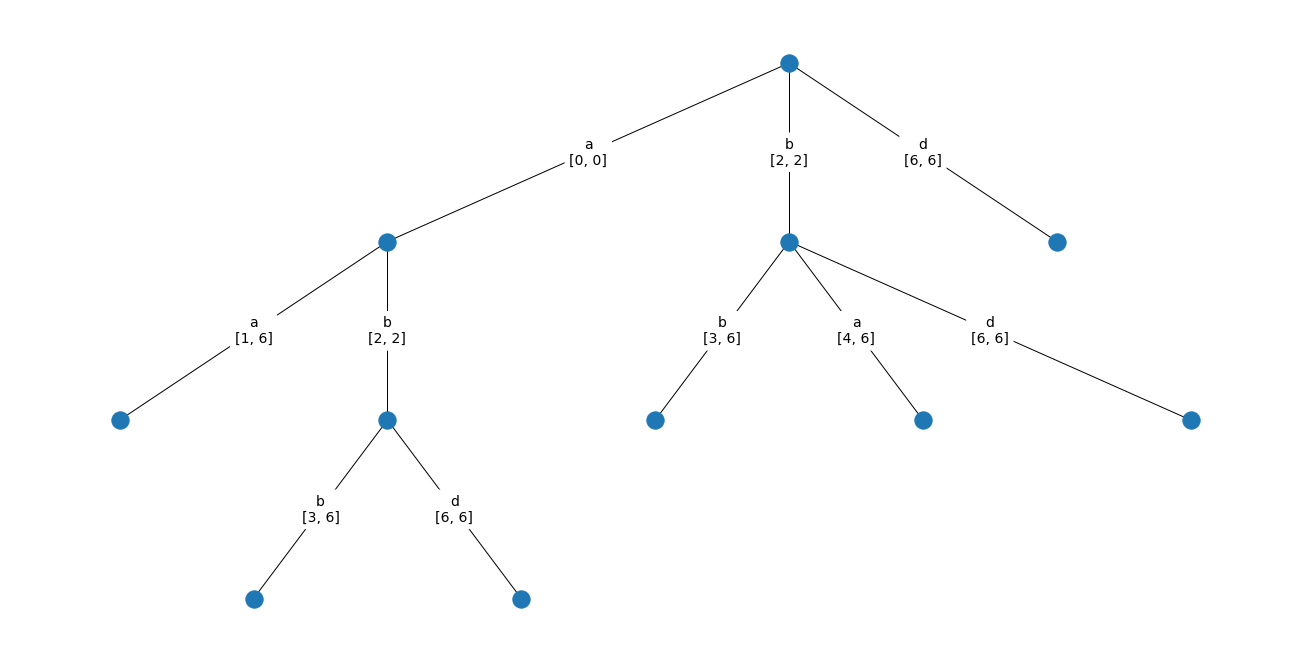

In [10]:
suffix_tree = SuffixTree("aabbabd")
tv = TreeVisualization()
tv.plot_suffix_tree(suffix_tree.root)

#### Sprawdzenie poprawności dla tekstu aabbabd

In [11]:
tests = [("aab", True), ("bbb", False), ("aba", False), ("bab", True), ("aabd", False), ("abbabd", True)]
check_correctness(trie, tests, "aabbabd", "Trie")
check_correctness(suffix_tree, tests, "aabbabd", "Suffix Tree")

Testowana struktura: Trie
Testowany tekst: aabbabd
 -> Wzorzec: aab         Poprawny wynik: True	  Otrzymany wynik: True
 -> Wzorzec: bbb         Poprawny wynik: False	  Otrzymany wynik: False
 -> Wzorzec: aba         Poprawny wynik: False	  Otrzymany wynik: False
 -> Wzorzec: bab         Poprawny wynik: True	  Otrzymany wynik: True
 -> Wzorzec: aabd        Poprawny wynik: False	  Otrzymany wynik: False
 -> Wzorzec: abbabd      Poprawny wynik: True	  Otrzymany wynik: True
Struktura danych jest poprawna

Testowana struktura: Suffix Tree
Testowany tekst: aabbabd
 -> Wzorzec: aab         Poprawny wynik: True	  Otrzymany wynik: True
 -> Wzorzec: bbb         Poprawny wynik: False	  Otrzymany wynik: False
 -> Wzorzec: aba         Poprawny wynik: False	  Otrzymany wynik: False
 -> Wzorzec: bab         Poprawny wynik: True	  Otrzymany wynik: True
 -> Wzorzec: aabd        Poprawny wynik: False	  Otrzymany wynik: False
 -> Wzorzec: abbabd      Poprawny wynik: True	  Otrzymany wynik: True
Struktu

## Tekst ababcd

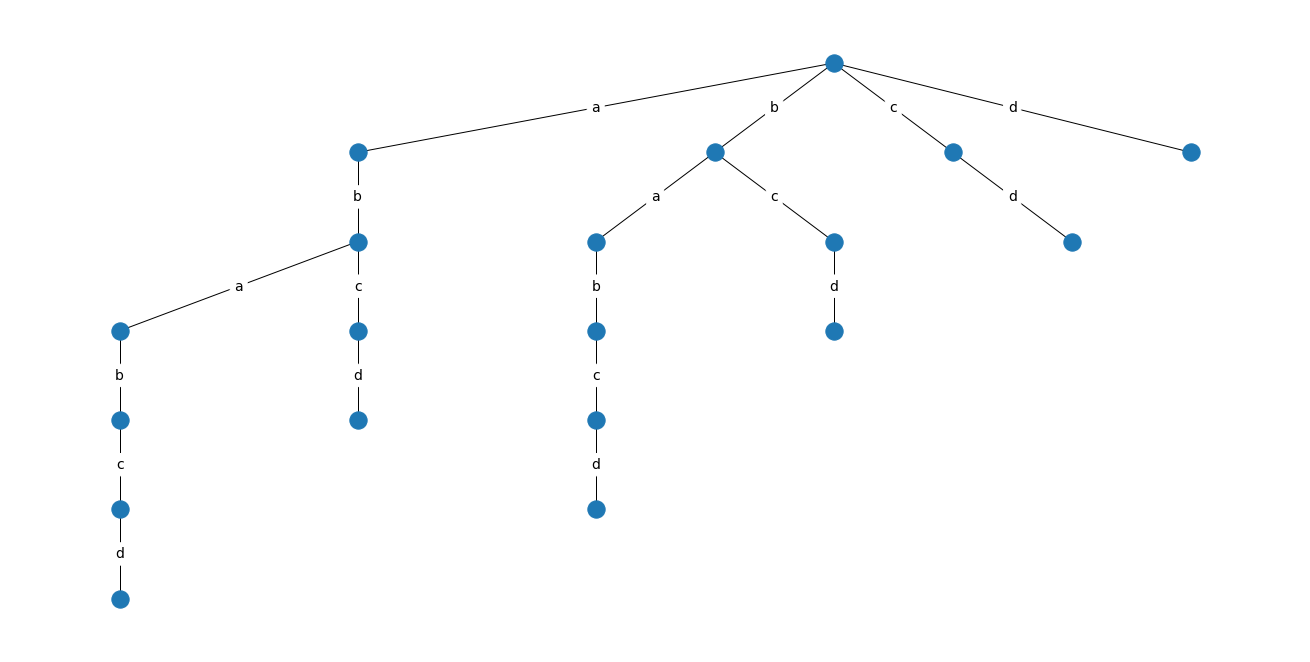

In [12]:
trie = Trie("ababcd")
tv = TreeVisualization()
tv.plot_trie_tree(trie.root)

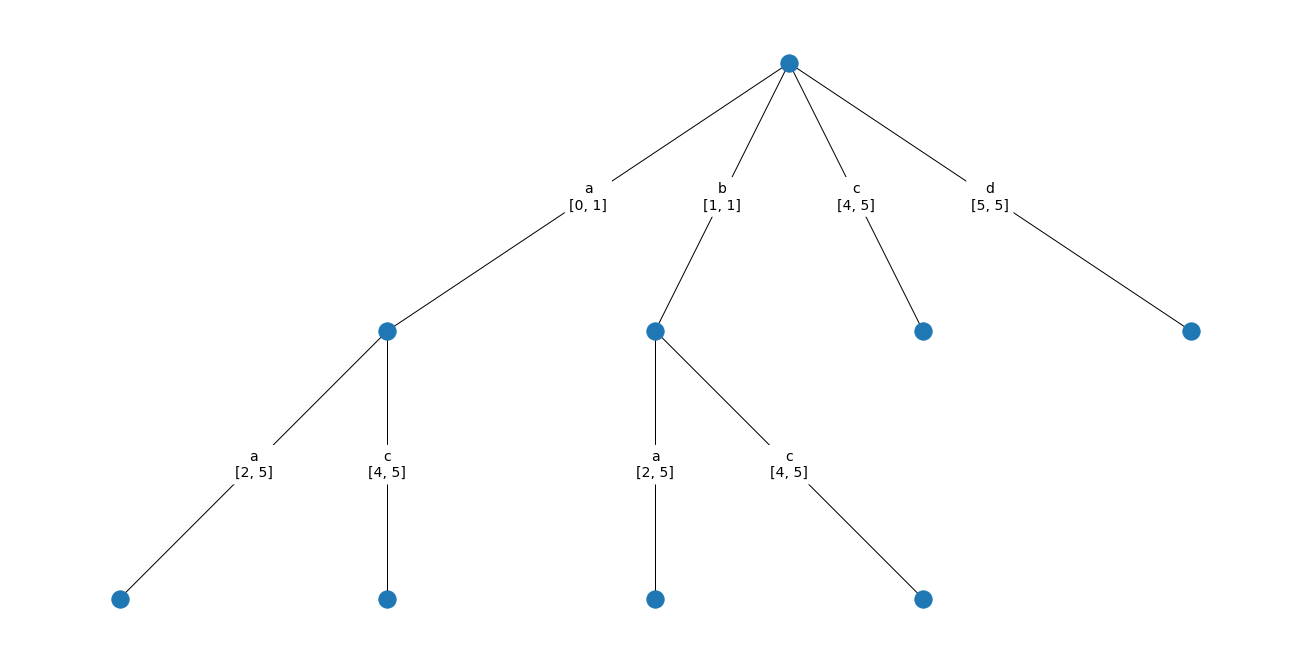

In [13]:
suffix_tree = SuffixTree("ababcd")
tv = TreeVisualization()
tv.plot_suffix_tree(suffix_tree.root)

#### Sprawdzenie poprawności dla tekstu ababcd

In [14]:
tests = [("ababc", True), ("abca", False), ("abcd", True), ("babc", True), ("abba", False), ("ababcda", False)]
check_correctness(trie, tests, "aabbabd", "Trie")
check_correctness(suffix_tree, tests, "aabbabd", "Suffix Tree")

Testowana struktura: Trie
Testowany tekst: aabbabd
 -> Wzorzec: ababc       Poprawny wynik: True	  Otrzymany wynik: True
 -> Wzorzec: abca        Poprawny wynik: False	  Otrzymany wynik: False
 -> Wzorzec: abcd        Poprawny wynik: True	  Otrzymany wynik: True
 -> Wzorzec: babc        Poprawny wynik: True	  Otrzymany wynik: True
 -> Wzorzec: abba        Poprawny wynik: False	  Otrzymany wynik: False
 -> Wzorzec: ababcda     Poprawny wynik: False	  Otrzymany wynik: False
Struktura danych jest poprawna

Testowana struktura: Suffix Tree
Testowany tekst: aabbabd
 -> Wzorzec: ababc       Poprawny wynik: True	  Otrzymany wynik: True
 -> Wzorzec: abca        Poprawny wynik: False	  Otrzymany wynik: False
 -> Wzorzec: abcd        Poprawny wynik: True	  Otrzymany wynik: True
 -> Wzorzec: babc        Poprawny wynik: True	  Otrzymany wynik: True
 -> Wzorzec: abba        Poprawny wynik: False	  Otrzymany wynik: False
 -> Wzorzec: ababcda     Poprawny wynik: False	  Otrzymany wynik: False
Struktu

## Tekst abcbccd

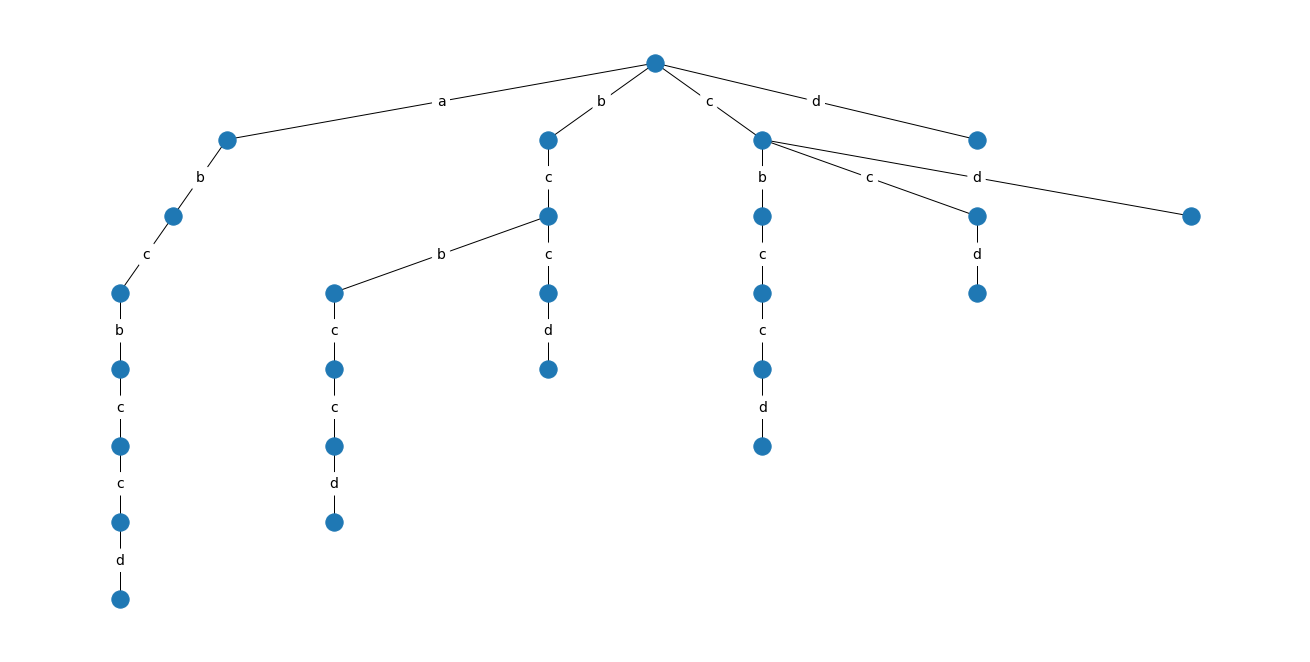

In [15]:
trie = Trie("abcbccd")
tv = TreeVisualization()
tv.plot_trie_tree(trie.root)

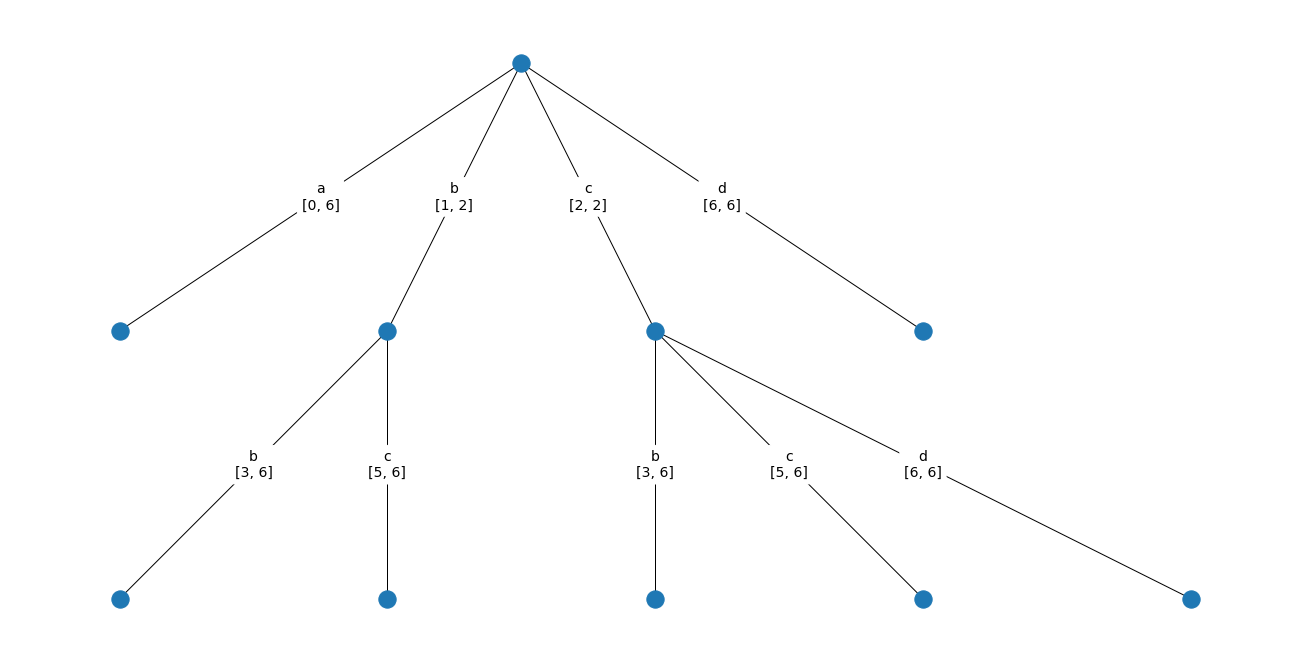

In [16]:
suffix_tree = SuffixTree("abcbccd")
tv = TreeVisualization()
tv.plot_suffix_tree(suffix_tree.root)

#### Sprawdzenie poprawności dla tekstu abcbccd

In [17]:
tests = [("abcbccd", True), ("abca", False), ("abcb", True), ("cbcc", True), ("abba", False), ("abcbcca", False)]
check_correctness(trie, tests, "aabbabd", "Trie")
check_correctness(suffix_tree, tests, "aabbabd", "Suffix Tree")

Testowana struktura: Trie
Testowany tekst: aabbabd
 -> Wzorzec: abcbccd     Poprawny wynik: True	  Otrzymany wynik: True
 -> Wzorzec: abca        Poprawny wynik: False	  Otrzymany wynik: False
 -> Wzorzec: abcb        Poprawny wynik: True	  Otrzymany wynik: True
 -> Wzorzec: cbcc        Poprawny wynik: True	  Otrzymany wynik: True
 -> Wzorzec: abba        Poprawny wynik: False	  Otrzymany wynik: False
 -> Wzorzec: abcbcca     Poprawny wynik: False	  Otrzymany wynik: False
Struktura danych jest poprawna

Testowana struktura: Suffix Tree
Testowany tekst: aabbabd
 -> Wzorzec: abcbccd     Poprawny wynik: True	  Otrzymany wynik: True
 -> Wzorzec: abca        Poprawny wynik: False	  Otrzymany wynik: False
 -> Wzorzec: abcb        Poprawny wynik: True	  Otrzymany wynik: True
 -> Wzorzec: cbcc        Poprawny wynik: True	  Otrzymany wynik: True
 -> Wzorzec: abba        Poprawny wynik: False	  Otrzymany wynik: False
 -> Wzorzec: abcbcca     Poprawny wynik: False	  Otrzymany wynik: False
Struktu

## Załączony tekst ustawy

In [18]:
f = open("1997_714_head.txt", "r", encoding="utf-8")
txt = f.read()
txt += "$"
f.close()

trie = Trie(txt)
suffix_tree = SuffixTree(txt)

#### Sprawdzenie poprawności dla tekstu ustawy

In [19]:
tests = [("ryczałtu", True),
         ("uczciwy", False),
         ("reguluje opodatkowanie zryczałtowanym podatkiem dochodowym niektórych", True),
         ("poz. 547, Nr 123, poz. 602 i Nr 126,", True),
         ("Osoby duchowne, prawnie uznanych wyznań, opłacają zryczałtowany podatek", True),
         ("Osoby duchowne, prawnie uznanych wyznań, opłacają zryczałtowane podatki", False),
         ("konstytucyjny", False)]

check_correctness(trie, tests, "1997_714_head.txt", "Trie", 20)
check_correctness(suffix_tree, tests, "1997_714_head.txt", "Suffix Tree", 20)

Testowana struktura: Trie
Testowany tekst: 1997_714_head.txt
 -> Wzorzec: ryczałtu              Poprawny wynik: True	  Otrzymany wynik: True
 -> Wzorzec: uczciwy               Poprawny wynik: False	  Otrzymany wynik: False
 -> Wzorzec: reguluje opodatko...  Poprawny wynik: True	  Otrzymany wynik: True
 -> Wzorzec: poz. 547, Nr 123,...  Poprawny wynik: True	  Otrzymany wynik: True
 -> Wzorzec: Osoby duchowne, p...  Poprawny wynik: True	  Otrzymany wynik: True
 -> Wzorzec: Osoby duchowne, p...  Poprawny wynik: False	  Otrzymany wynik: False
 -> Wzorzec: konstytucyjny         Poprawny wynik: False	  Otrzymany wynik: False
Struktura danych jest poprawna

Testowana struktura: Suffix Tree
Testowany tekst: 1997_714_head.txt
 -> Wzorzec: ryczałtu              Poprawny wynik: True	  Otrzymany wynik: True
 -> Wzorzec: uczciwy               Poprawny wynik: False	  Otrzymany wynik: False
 -> Wzorzec: reguluje opodatko...  Poprawny wynik: True	  Otrzymany wynik: True
 -> Wzorzec: poz. 547, Nr 123,.

## Porównanie szybkości działania

Dla danych z punktów 1-4 czasy były zbyt krótkie, aby je poprawnie zmierzyć, w związku z tym do porównania wykorzystany został jedynie załączony tekst ustawy.

In [20]:
f = open("1997_714_head.txt", "r")
txt = f.read()
txt += "$"
f.close()

start = time()
trie = Trie(txt)
print("Trie", round(time() - start, 3))

start = time()
suffix_tree = SuffixTree(txt)
print("Suffix Tree", round(time() - start, 3))

Trie 6.135
Suffix Tree 0.013


| Nazwa struktury | Czas tworzenia struktury [s] |
|-----------------|------------------------------|
| Trie            | 6.135                        |
| Suffix Tree     | 0.013                        |